In [1]:
import os
import torch
import clip
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
from torchvision.datasets import CIFAR100
device = "cuda" if torch.cuda.is_available() else "cpu"

# CLIP

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3. We found CLIP matches the performance of the original ResNet50 on ImageNet “zero-shot” without using any of the original 1.28M labeled examples, overcoming several major challenges in computer vision.

## CLIP Text2Image engine search - CIFAR100

In the example below we will reverse the common use of CLIP and instead of checking a match between a group of tasks and one picture we will check a match between a group of pictures and one text.

In fact, we will create an image search engine by text.

In [2]:
img_id = 3
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)
img = cifar100[img_id][0].resize((100,100))
image_pool = [cifar100[i][0] for i in range(10000)]

Files already downloaded and verified


In [3]:
import torch
import clip
from PIL import Image

# Load the model
model, preprocess = clip.load('ViT-B/32', device=device)

# Assuming image_pool is a list of PIL.Image objects
image_embeddings = []

# Calculate the embeddings for each image
with torch.no_grad():
    for image in image_pool:
        image_input = preprocess(image).unsqueeze(0).to(device)
        image_features = model.encode_image(image_input)
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        image_embeddings.append(image_features)

In [9]:
def search(prompt):
    # Tokenize and encode the text prompt
    text_input = clip.tokenize(prompt).to(device)

    # Calculate the text features
    with torch.no_grad():
        text_features = model.encode_text(text_input)
        # Normalize features
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Assuming image_embeddings is loaded with the embeddings from Part 1
    similarity_scores = torch.zeros(len(image_embeddings))

    # Calculate similarity for each image embedding
    with torch.no_grad():
        for i, image_features in enumerate(image_embeddings):
            similarity = (image_features @ text_features.T).squeeze(0)
            similarity_scores[i] = similarity

    # Find the index of the highest similarity score
    max_index = similarity_scores.argmax()

    # Output the most similar image
    print(f"Most similar image is at index {max_index} with a similarity score of {similarity_scores[max_index].item()}")
    return image_pool[max_index].resize((200,200))

Most similar image is at index 3809 with a similarity score of 0.303466796875


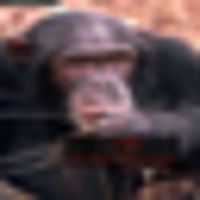

In [16]:
search('Chimpanzee')

Most similar image is at index 6947 with a similarity score of 0.2763671875


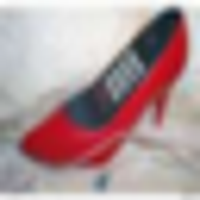

In [13]:
search('Red shoe')

Most similar image is at index 1013 with a similarity score of 0.28369140625


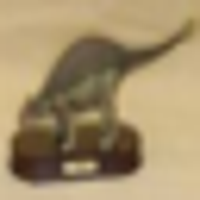

In [11]:
search('Dinosaur')

Most similar image is at index 9404 with a similarity score of 0.28857421875


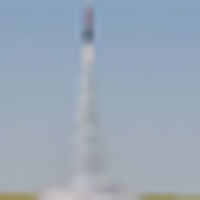

In [17]:
search('Rocket Ship')

Now we will create neat functions for embedding, searching and visualizing images

In [28]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

def calculate_image_embeddings(image_pool, device='cuda'):
    """
    Calculate and save embeddings for a pool of images.
    
    Parameters:
    - image_pool: A list of PIL.Image objects.
    - device: Computation device, 'cuda' or 'cpu'.
    
    Returns:
    - A list of image embeddings.
    """
    # Load the model
    model, preprocess = clip.load('ViT-B/32', device=device)
    
    image_embeddings = []
    
    # Calculate the embeddings for each image
    with torch.no_grad():
        for image in image_pool:
            image_input = preprocess(image).unsqueeze(0).to(device)
            image_features = model.encode_image(image_input)
            # Normalize features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            image_embeddings.append(image_features)
    
    return image_embeddings

def encode_text_and_calculate_similarity(text_prompt, image_embeddings, model, device):
    """
    Tokenize and encode a text prompt, then calculate similarity scores with image embeddings.
    
    Returns:
    - similarity_scores: A tensor of similarity scores between the text and each image embedding.
    """
    # Tokenize and encode the text prompt
    text_input = clip.tokenize(f'a photo of a {text_prompt}').to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(text_input)
        # Normalize features
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        similarity_scores = torch.tensor([torch.matmul(image_features, text_features.T).squeeze(0) 
                                           for image_features in image_embeddings], device=device)
    return similarity_scores

def find_most_similar_image(text_prompt, image_embeddings, image_pool, plot=True, device='cuda'):
    """
    Calculate similarity between a text prompt and pre-calculated image embeddings,
    returning the index of the most similar image.
    """
    model, _ = clip.load('ViT-B/32', device=device)
    
    similarity_scores = encode_text_and_calculate_similarity(text_prompt, image_embeddings, model, device)
    max_index = similarity_scores.argmax()
    max_score = similarity_scores[max_index].item()
    
    if plot:
        plt.imshow(image_pool[max_index])
        plt.title(f'Index: {max_index}, Similarity Score: {max_score:.2f}')
        plt.axis('off')
        plt.show()
        
    return max_index, max_score, image_pool[max_index]

def find_and_display_similar_images(prompts, image_embeddings, image_pool, plot=True, device='cuda'):
    """
    For each prompt, find the most similar image and display images in rows of 3,
    showing the prompt, its index, and similarity score.
    """
    model, _ = clip.load('ViT-B/32', device=device)
    
    num_prompts = len(prompts)
    if plot:
        plt.figure(figsize=(15, 5 * ((num_prompts + 2) // 3)))  # Adjusted for proper ceil division
    
    for idx, prompt in enumerate(prompts, start=1):
        similarity_scores = encode_text_and_calculate_similarity(prompt, image_embeddings, model, device)
        max_index = similarity_scores.argmax()
        max_score = similarity_scores[max_index].item()
        if plot:
            plt.subplot((num_prompts + 2) // 3, 3, idx)  # Adjust for a more dynamic layout
            plt.imshow(image_pool[max_index])
            plt.title(f'Prompt: {prompt}\nIndex: {max_index}, Score: {max_score:.2f}')
            plt.axis('off')
    if plot:
        plt.tight_layout()
        plt.show()
        
def plot_image(image, size = (450, 280)):
    return image.resize(size)

# BDD100K Natural Language Questions

## CLIP Text2Image engine search - BDD100K

In [7]:
# Define the base paths
BASE_PATH = Path('bdd100k')
INPUT_PATH = BASE_PATH/'images'
TARGET_PATH = BASE_PATH/'labels'

In [8]:
image_pool = []
for subpath in os.listdir(INPUT_PATH):
    for img_path in os.listdir(INPUT_PATH/subpath):
        image_pool.append(Image.open((INPUT_PATH/subpath)/img_path))

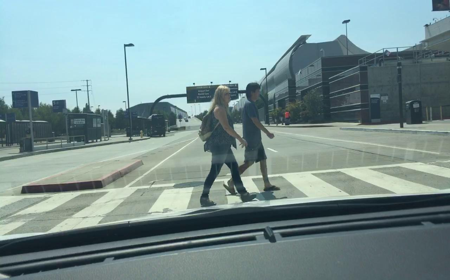

In [29]:
plot_image(image_pool[0])

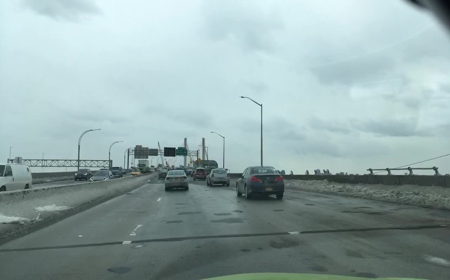

In [30]:
plot_image(image_pool[1])

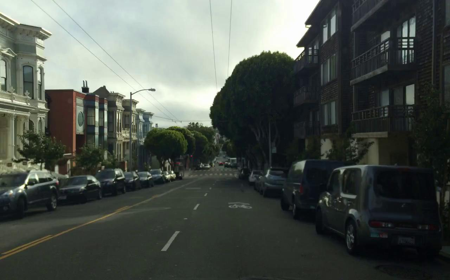

In [31]:
plot_image(image_pool[2])

We will convert the images into embeddED vectors with CLIP

In [13]:
%%time
bdd100k_embeddings = calculate_image_embeddings(image_pool)

CPU times: user 4min 15s, sys: 6.05 s, total: 4min 21s
Wall time: 2min 6s


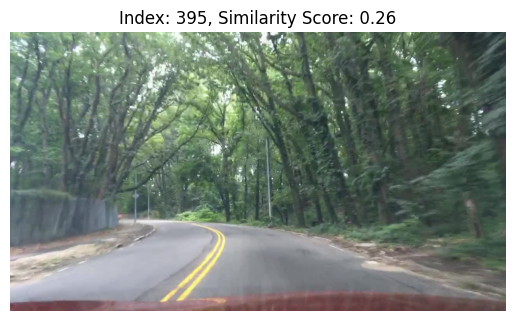

CPU times: user 3.03 s, sys: 784 ms, total: 3.81 s
Wall time: 3.26 s


In [18]:
%%time
prompt = 'Forest'
max_index, max_score, image = find_most_similar_image(prompt, bdd100k_embeddings, image_pool)

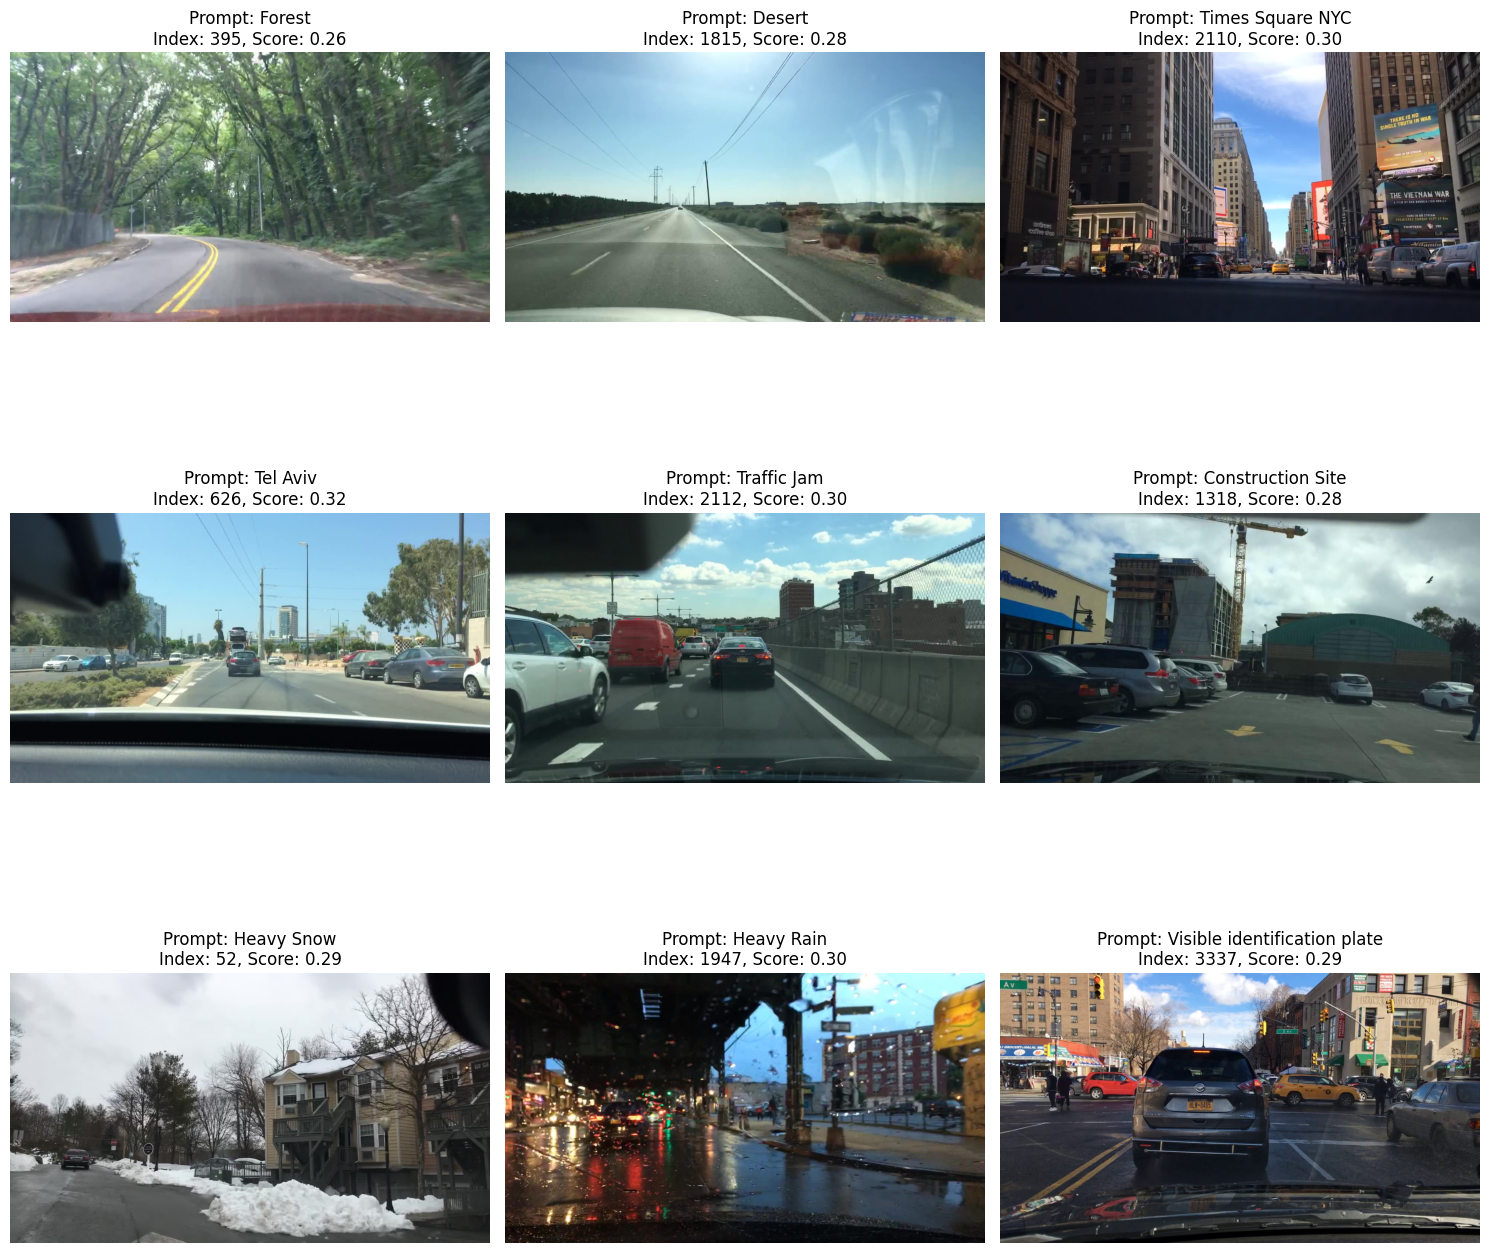

In [19]:
find_and_display_similar_images(
    prompts = ['Forest', 'Desert', 'Times Square NYC', 'Tel Aviv', 'Traffic Jam', 'Construction Site', 'Heavy Snow', 'Heavy Rain', 'Visible identification plate'],
    image_embeddings = bdd100k_embeddings,
    image_pool = image_pool
)

## Llava

The subsequent segment delineates the operational framework and outcomes facilitated by the pipeline. The process is delineated as follows:

- Initially, the pipeline transforms the entirety of the image database into vector representations utilizing the CLIP model.

- Upon receiving a specific query, a technique akin to few-shot learning is employed to instruct the LLaVA model on extracting pertinent anchors from the query. These anchors serve as the basis for identifying the relevant image in the subsequent step.

- The extracted anchors are then vectorized, enabling the identification of the image vector that most closely aligns with these anchor vectors.

- Following the identification of the image that corresponds to the anchors present in the initial query, the pipeline revisits LLaVA, requesting it to formulate a response to the user's original question, referencing the identified image.

- The process culminates in the presentation of both the located image and LLaVA's generated response within the user interface, offering a comprehensive answer to the user's query.

In [2]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [3]:
from transformers import pipeline

model_id = "llava-hf/vip-llava-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
prompt_prefix_extract_qwary = """USER: <image>\n
Guideline for Extracting Anchors for Image Retrieval Based on Similarity

Task Overview:
Your objective is to extract anchors from textual descriptions or queries. An anchor is a pivotal concept, often encapsulating crucial elements such as location, the central subject of an image, or distinctive features mentioned in the text. These anchors serve as the key for locating and retrieving images from a database, based on their similarity to the described elements. The extraction process should hone in on those aspects of the text that most directly inform the search for a relevant image.

The Importance of Extracting Anchors:
Extracting anchors efficiently directs the process of image retrieval by:

Highlighting the most relevant features, locations, or subjects within a query that are key to finding a closely matching image.
Enhancing the precision of search results in an image database by using detailed and specific criteria.
Supporting few-shot learning by emphasizing critical information that aids in the quick adaptation to and understanding of new retrieval tasks.
Examples of Anchor Extraction with More Complexity:

Question: "Show me a panoramic view of Machu Picchu during the golden hour for a travel brochure."
Anchor: "Machu Picchu"

Question: "I need a high-resolution image depicting the hustle and bustle of Tokyo's Shibuya Crossing at night for a cultural presentation."
Anchor: "Tokyo Shibuya Crossing".

Question:"""
empty_image = Image.new('RGB', (10, 10))

In [15]:
user_prompt = 'Can you update me on the traffic situation on the road in the nearby forest?'

In [16]:
prompt = prompt_prefix_extract_qwary + user_prompt
outputs = pipe(empty_image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
qwary = outputs[0]["generated_text"].split(user_prompt)[-1].split('\n')[1].split('Anchor')[-1].split('"')[1] 
qwary

'forest'

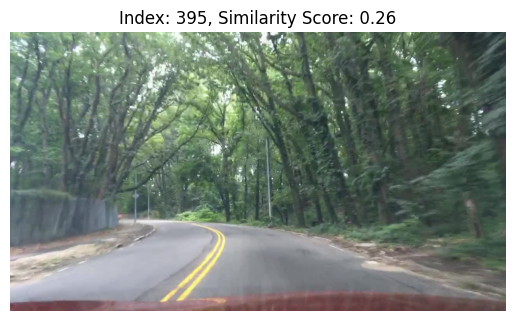

In [17]:
max_index, max_score, image = find_most_similar_image(qwary, bdd100k_embeddings, image_pool)

In [18]:
prompt_prefix_get_anser = """USER: <image>
Attached is a photo of a forest.
Based on the content of the picture, briefly answer the following question only:

What is the current traffic situation in the forest?

Please note, you must respond as a personal assistant and not describe what is in the photo but answer the user what the answer to his question is based on the latest photo from the field only
ASSISTANT:"""

In [19]:
outputs = pipe(image, prompt=prompt_prefix_get_anser, generate_kwargs={"max_new_tokens": 200})
anser = outputs[0]["generated_text"].split('ASSISTANT: ')[-1]
anser

'There is no traffic in the forest.'

In [43]:
def extract_anchor_and_get_answer(pipe, user_prompt, bdd100k_embeddings, image_pool):
    """
    Extracts anchors from textual descriptions or queries, and provides an answer based on a specific question and image.
    
    Args:
        pipe (callable): The function to call the appropriate model pipeline.
        user_prompt (str): The user's textual description or query.
        image (PIL.Image): The image based on which the answer is generated.
        
    Returns:
        tuple: A tuple containing the extracted anchor and the answer to the query.
    """
    # Define the prefix for extracting anchors
    prompt_prefix_extract_qwary = """USER: <image>\n
    Guideline for Extracting Anchors for Image Retrieval Based on Similarity

    Task Overview:
    Your objective is to extract anchors from textual descriptions or queries. An anchor is a pivotal concept, often encapsulating crucial elements such as location, the central subject of an image, or distinctive features mentioned in the text. These anchors serve as the key for locating and retrieving images from a database, based on their similarity to the described elements. The extraction process should hone in on those aspects of the text that most directly inform the search for a relevant image.

    The Importance of Extracting Anchors:
    Extracting anchors efficiently directs the process of image retrieval by:

    Highlighting the most relevant features, locations, or subjects within a query that are key to finding a closely matching image.
    Enhancing the precision of search results in an image database by using detailed and specific criteria.
    Supporting few-shot learning by emphasizing critical information that aids in the quick adaptation to and understanding of new retrieval tasks.
    Examples of Anchor Extraction with More Complexity:

    Question: "Show me a panoramic view of Machu Picchu during the golden hour for a travel brochure."
    Anchor: "Machu Picchu"

    Question: "I need a high-resolution image depicting the hustle and bustle of Tokyo's Shibuya Crossing at night for a cultural presentation."
    Anchor: "Tokyo Shibuya Crossing".

    Question:"""

    # Generate the full prompt for anchor extraction
    prompt_for_extraction = prompt_prefix_extract_qwary + user_prompt
    empty_image = Image.new('RGB', (10, 10))  # Placeholder image for the text-to-text task
    extraction_outputs = pipe(empty_image, prompt=prompt_for_extraction, generate_kwargs={"max_new_tokens": 200})
    qwary = extraction_outputs[0]["generated_text"].split(user_prompt)[-1].split('\n')[1].split('Anchor')[-1].split('"')[1]

    # Define the prefix for getting an answer based on an image
    prompt_prefix_get_anser = f"""USER: <image>
    Attached is a photo of {qwary}.
    Based on the content of the picture, briefly answer the following question only:
    {user_prompt}
    Please note, you must respond as a personal assistant and not describe what is in the photo but answer the user what the answer to his question is based on the latest photo from the field only
    ASSISTANT:"""
    max_index, max_score, image = find_most_similar_image(qwary, bdd100k_embeddings, image_pool, plot = False)
    # Generate the full prompt for getting an answer
    answer_outputs = pipe(image, prompt=prompt_prefix_get_anser, generate_kwargs={"max_new_tokens": 200})
    answer = answer_outputs[0]["generated_text"].split('ASSISTANT: ')[-1]

    return image, answer, qwary

user_prompt: I want to pass by Time Square on the way home, is the traffic busy there?
qwary: Time Square
answer: Yes, the traffic is busy in Time Square.
CPU times: user 12 s, sys: 1.02 s, total: 13 s
Wall time: 12.5 s


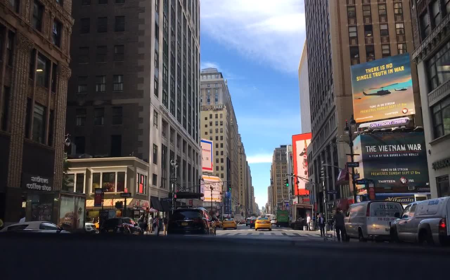

In [45]:
%%time
user_prompt = 'I want to pass by Time Square on the way home, is the traffic busy there?'
image, answer, qwary = extract_anchor_and_get_answer(pipe, user_prompt, bdd100k_embeddings, image_pool)
print(f'user_prompt: {user_prompt}')
print(f'qwary: {qwary}')
print(f'answer: {answer}')
plot_image(image)

user_prompt: I'm going to visit my family for the holidays via the Golden Bridge, is the road busy?
qwary: Golden Bridge
answer: Yes, the road is busy.
CPU times: user 11.8 s, sys: 833 ms, total: 12.7 s
Wall time: 12.1 s


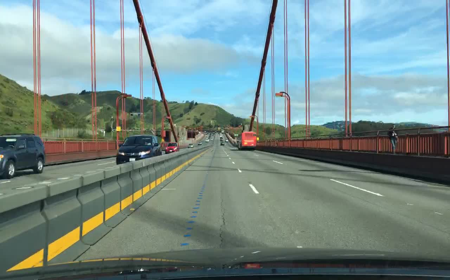

In [34]:
%%time
user_prompt = "I'm going to visit my family for the holidays via the Golden Bridge, is the road busy?"
image, answer, qwary = extract_anchor_and_get_answer(pipe, user_prompt, bdd100k_embeddings, image_pool)
print(f'user_prompt: {user_prompt}')
print(f'qwary: {qwary}')
print(f'answer: {answer}')
plot_image(image)

user_prompt: I am going to drive to JFK airport, and I planned to leave at 07:30 in the morning. Should I be early because of the traffic congestion or is the traffic flowing?
qwary: JFK airport
answer: The traffic is flowing, so you should be able to get there on time.
CPU times: user 12.2 s, sys: 1.01 s, total: 13.2 s
Wall time: 12.6 s


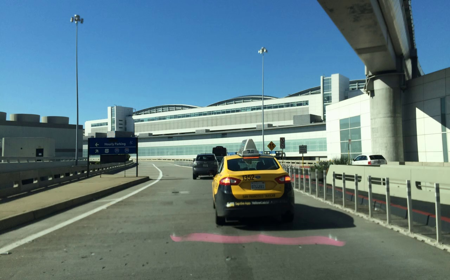

In [52]:
%%time
user_prompt = "I am going to drive to JFK airport, and I planned to leave at 07:30 in the morning. Should I be early because of the traffic congestion or is the traffic flowing?"
image, answer, qwary = extract_anchor_and_get_answer(pipe, user_prompt, bdd100k_embeddings, image_pool)
print(f'user_prompt: {user_prompt}')
print(f'qwary: {qwary}')
print(f'answer: {answer}')
plot_image(image)